In [3]:
import pandas as pd
import numpy as np
import statsmodels
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
import seaborn
import dateutil
from datetime import datetime
import math
import plotly.graph_objects as go
import plotly.express as px


In [4]:
symbols = ['LUV.US','GD.US']
#symbols = ['LUV.US','AAL.US', 'DAL.US', 'UAL.US', 'ATSG.US', 'SKYW.US', 'ALGT.US', 'GD.US', 'ALK.US', 'HA.US']




# Get Data

In [5]:
quotes = pd.DataFrame()
#start = '2010-01-1' ## Anti correlated period - starts with a massive drop
start = '2015-01-1'
end = '2020-03-30'

In [6]:
for s in symbols:
    print(s)
    endpoint = f'https://eodhistoricaldata.com/api/eod/{s}?from={start}&to={end}&api_token=5d7111a684ee90.02476162&interval=d&fmt=csv'
    df = pd.read_csv(endpoint)
    df = df[df['Adjusted_close'] > 0]
    #print(df.head(1))
    if len(quotes) == 0:
        quotes['Date'] = df['Date']
        quotes[s] = df['Adjusted_close']
    else:
        new_df = pd.DataFrame()
        new_df['Date'] = df['Date']
        new_df[s] = df['Adjusted_close']
        quotes = quotes.merge(new_df, how="inner", on="Date")
    #print(quotes)
#print(quotes.tail(20))

LUV.US
GD.US


In [7]:
old_quotes = quotes
#quotes=old_quotes

#print(quotes)


In [8]:
quotes = quotes.dropna()
quotes = quotes.reset_index()
quotes['Date'] = pd.to_datetime(quotes['Date'])
quotes = quotes.set_index('Date')
#quotes = quotes[quotes.index > dateutil.parser.parse("2020-03-01")]
#print(quotes)

# Understand cointegration

In [9]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            #print(result)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

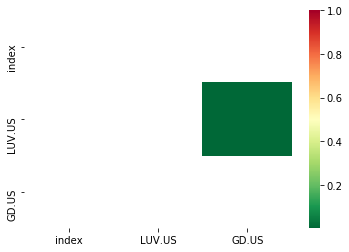

[('LUV.US', 'GD.US')]


In [10]:
data = quotes
scores, pvalues, pairs = find_cointegrated_pairs(data)
m = [0,0.2,0.4,0.6,0.8,1]
seaborn.heatmap(pvalues, xticklabels=data.columns, 
                yticklabels=data.columns, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.80)
                )
plt.show()
print(pairs)


### Initial analysis of ratio and zscore. Do they go back to a mean?

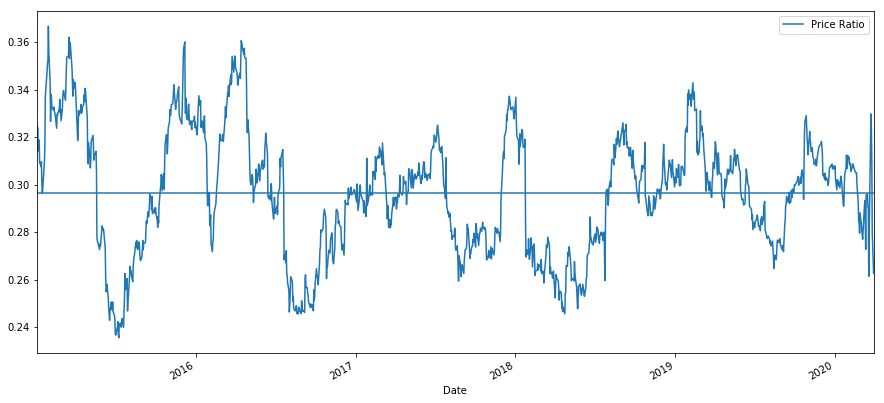

In [11]:
chosen = ['LUV.US', 'GD.US']
S1 = quotes[chosen[0]]
S2 = quotes[chosen[1]]

score, pvalue, _ = coint(S1, S2)
ratios = S1 / S2
ratios.plot(figsize=(15,7))
plt.axhline(ratios.mean())
plt.legend(['Price Ratio'])
plt.show()

In [12]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

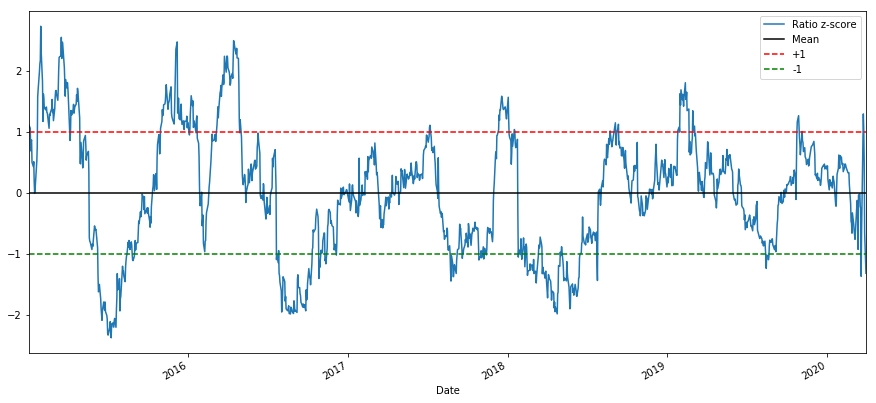

In [13]:
zscores = zscore(ratios)
zscores.plot(figsize=(15,7))
#print(zscores)
plt.axhline(zscore(ratios).mean(), color='black')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.legend(['Ratio z-score', 'Mean', '+1', '-1'])
plt.show()

# Variables

In [14]:
# Indicators
moving_avg_1 = 40 #default 60
moving_avg_2 = 5 # default 5
macd_fast = 1
macd_slow = 2

# Trading limits
limit = 0.75 #default 1
exit_limit = 0.5 #default -.75
leverage_limit = 1.2
max_leverage = 2
vol_limit= 0.0115


# Identify features
- Slow Moving Average of Ratio: Check Variables
- Fast Moving Average of Ratio: Check Variables
- Standard Deviation (Based on Slow Moving AVG) 
- z score: (FastMA — SlowMA) / STD
- macd

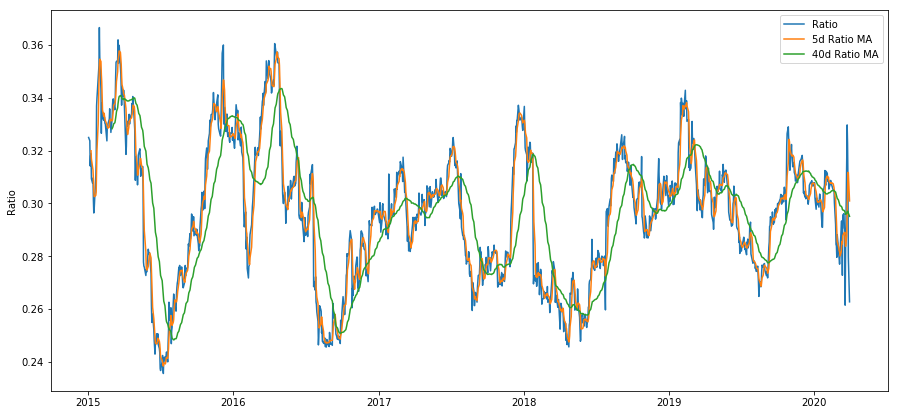

In [15]:
moving_avg_fast = ratios.rolling(window=moving_avg_2,
                               center=False).mean()
moving_avg_slow = ratios.rolling(window=moving_avg_1,
                               center=False).mean()
std_60 = ratios.rolling(window=moving_avg_1,
                        center=False).std()
zscore_moving_avg = (moving_avg_fast - moving_avg_slow)/std_60
plt.figure(figsize=(15,7))
plt.plot(ratios.index, ratios.values)
plt.plot(moving_avg_fast.index, moving_avg_fast.values)
plt.plot(moving_avg_slow.index, moving_avg_slow.values)
plt.legend(['Ratio',f'{moving_avg_2}d Ratio MA', f'{moving_avg_1}d Ratio MA'])
plt.ylabel('Ratio')
plt.show()

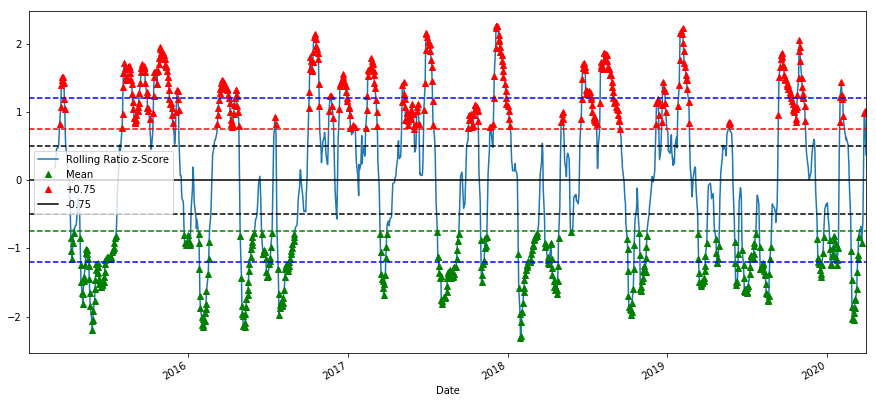

In [16]:
plt.figure(figsize=(15,7))
zscore_moving_avg.plot()

#buy_with_leverage = zscore_moving_avg.copy()
#buy_with_leverage[zscore_moving_avg>-leverage_limit] = None

#sell_with_leverage = zscore_moving_avg.copy()
#sell_with_leverage[zscore_moving_avg<leverage_limit] = None

buy = zscore_moving_avg.copy()
buy[zscore_moving_avg>-limit] = None

sell = zscore_moving_avg.copy()
sell[zscore_moving_avg<limit] = None

buy.plot(color='g', linestyle='None', marker='^')
sell.plot(color='r', linestyle='None', marker='^')


#buy_with_leverage.plot(color='black', linestyle='None', marker='^')
#sell_with_leverage.plot(color='black', linestyle='None', marker='^')

plt.axhline(0, color='black')
plt.axhline(limit, color='red', linestyle='--')
plt.axhline(-limit, color='green', linestyle='--')
plt.axhline(leverage_limit, color='blue', linestyle='--')
plt.axhline(-leverage_limit, color='blue', linestyle='--')
plt.axhline(exit_limit, color='black', linestyle='--')
plt.axhline(-exit_limit, color='black', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+'+str(limit), '-'+str(limit)])
plt.show()

In [17]:
zscores_frame = zscore_moving_avg.to_frame()
#print(zscores_frame)
macd_high = zscore_moving_avg.ewm(span=macd_fast, adjust=False).mean()
macd_low = zscore_moving_avg.ewm(span=macd_slow, adjust=False).mean()
#macd_high = exp1-exp2
#macd_low = macd.ewm(span=9, adjust=False).mean()


plt.figure(figsize=(15,7))
fig = go.Figure()

#print(macd_low)
fig.add_trace(go.Scatter(x=macd_high.index, y=macd_high,
                    mode='lines',
                    name='high'))

fig.add_trace(go.Scatter(x=macd_low.index, y=macd_low,
                    mode='lines',
                    name='low'))



fig.show()

<Figure size 1080x504 with 0 Axes>

### Volatility

In [18]:
ratios_vol = pd.DataFrame(index=ratios.index, columns=['Vol'])
limit_line = pd.DataFrame(index=ratios.index, columns=['Limit'], data=len(ratios)*[vol_limit])
#print(ratios_vol)

interval = 20
for i in range(interval, len(S1)):
    date = ratios.index[i]
    r = ratios[i-interval : i]
    vol = r.std()
    ratios_vol.loc[date]['Vol'] = vol

plt.figure(figsize=(20,7))
fig = go.Figure()

#print(macd_low)
fig.add_trace(go.Scatter(x=ratios_vol.index, y=ratios_vol['Vol'],
                    mode='lines',
                    name='Vol'))
fig.add_trace(go.Scatter(x=limit_line.index, y=limit_line['Limit'],
                    mode='lines',
                    name='Limit'))

fig.show()

<Figure size 1440x504 with 0 Axes>

## Trading algo

In [19]:
def get_holding_return_on_close(holding):
    if holding['type'] == 'BUY':
        holding['return'] = (holding['sold_at'] / holding['bought_at'] -1) * holding['leverage']
    else:
        holding['return'] = (1 - holding['sold_at'] / holding['bought_at'])  * holding['leverage']
    holding['nav'] = holding['amount'] + (holding['return'] * holding['amount'])
    return holding


In [20]:
def get_open_holding_nav(holding, current_price):
    if holding['type'] == 'BUY':
        holding['return'] = (current_price / holding['bought_at'] -1) * holding['leverage']
    else:
        holding['return'] = (1 - current_price / holding['bought_at']) * holding['leverage']
    holding['nav'] = holding['amount'] + (holding['return'] * holding['amount'])
    return holding['nav']

In [21]:
# Trade using a simple strategy
# If window length is 0, algorithm doesn't make sense, so exit
def trade(S1, S2):
    portfolio = {
        'cash': 10000,
        'nav': 10000,
        'holdings': {
            's1': None,
            's2': None
        },
        'history': pd.DataFrame(columns=["symbol", "type", "amount", "bought_at", "bought_on", "status"]),
        'nav': pd.DataFrame(columns=['date', 'nav'])
    }
    prices = pd.DataFrame(columns=["Date", "Action", "Price"])
    
    old_trend = ""
    new_trend = ""
    indicator = zscore_moving_avg
    for i in range(len(indicator)):
        date = indicator.index[i]
        print(ratios_vol.loc[date])
        within_vol = not math.isnan(ratios_vol.loc[date]['Vol']) and ratios_vol.loc[date]['Vol'] < vol_limit
        print(within_vol)
        if macd_low[indicator.index[i]] <= macd_high[indicator.index[i]]:
            new_trend = "UP"
        else:
            new_trend = "DOWN"
            
       # dates.append
        # Sell short if the z-score is > 1
        if indicator[i] > limit and new_trend == "DOWN" and within_vol:
            if portfolio['holdings']['s1'] == None and portfolio['holdings']['s2'] == None:
                amount = portfolio['cash'] * 0.5
                leverage = 1
                if indicator[i] > leverage_limit:
                    leverage = max_leverage
                    
                portfolio['holdings']['s1'] = {'amount': amount, 'bought_at': S1.loc[indicator.index[i]], 'type': 'SELL', 'bought_on': indicator.index[i], 'symbol': chosen[0], 'status': 'OPEN', 'leverage': leverage}
                portfolio['holdings']['s2'] = {'amount': amount, 'bought_at': S2.loc[indicator.index[i]], 'type': 'BUY', 'bought_on': indicator.index[i], 'symbol': chosen[1], 'status': 'OPEN', 'leverage': leverage}
                portfolio['cash'] = portfolio['cash'] - amount*2
                
        # Buy long if the z-score is < 1
        elif indicator[i] < -limit and new_trend == "UP" and within_vol:
            if portfolio['holdings']['s1'] == None and portfolio['holdings']['s2'] == None:
                amount = portfolio['cash'] * 0.5
                leverage = 1
                if indicator[i] < -leverage_limit:
                    leverage = max_leverage
                    
                portfolio['holdings']['s1'] = {'amount': amount, 'bought_at': S1.loc[indicator.index[i]], 'type': 'BUY', 'bought_on': indicator.index[i], 'symbol': chosen[0], 'status': 'OPEN', 'leverage': leverage}
                portfolio['holdings']['s2'] = {'amount': amount, 'bought_at': S2.loc[indicator.index[i]], 'type': 'SELL', 'bought_on': indicator.index[i], 'symbol': chosen[1], 'status': 'OPEN', 'leverage': leverage}
                portfolio['cash'] = portfolio['cash'] - amount*2
        
        # Clear positions if the z-score between -.5 and .5
        elif abs(indicator[i]) < exit_limit or not within_vol:
            if portfolio['holdings']['s1'] != None and portfolio['holdings']['s2'] != None:
                s1_res =  portfolio['holdings']['s1']
                s1_res['sold_on'] =  indicator.index[i]
                s1_res['sold_at'] =  S1.loc[indicator.index[i]]
                s1_res['status'] = 'CLOSE'
                s1_res = get_holding_return_on_close(s1_res)
                
                s2_res =  portfolio['holdings']['s2']
                s2_res['sold_on'] =  indicator.index[i]
                s2_res['sold_at'] =  S2.loc[indicator.index[i]]
                s2_res['status'] = 'CLOSE'
                s2_res = get_holding_return_on_close(s2_res)

                portfolio['cash'] = s1_res['nav'] + s2_res['nav']
                
                portfolio['nav'] = portfolio['nav'].append({'date': indicator.index[i], 'nav': portfolio['cash']}, ignore_index=True)

                portfolio['history'] = portfolio['history'].append(s1_res, ignore_index=True)
                portfolio['history'] = portfolio['history'].append(s2_res, ignore_index=True)

                portfolio['holdings']['s1'] = None
                portfolio['holdings']['s2'] = None

                #print('Exit')
        
        holdings_nav = 0
        if portfolio['holdings']['s1'] != None and portfolio['holdings']['s2'] != None:
            s1_nav = get_open_holding_nav(portfolio['holdings']['s1'], S1.loc[indicator.index[i]])
            s2_nav = get_open_holding_nav(portfolio['holdings']['s2'], S2.loc[indicator.index[i]])
            holdings_nav = s1_nav + s2_nav

        portfolio['nav'] = portfolio['nav'].append({'date': indicator.index[i], 'nav': portfolio['cash'] + holdings_nav}, ignore_index=True)
        
        old_trend = new_trend
        #print(portfolio['history'])
            
            #print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))
    
    portfolio['nav'] = portfolio['nav'].set_index('date')
    return portfolio

portfolio = trade(quotes[chosen[0]],quotes[chosen[1]])



Vol    NaN
Name: 2015-01-02 00:00:00, dtype: object
False
Vol    NaN
Name: 2015-01-05 00:00:00, dtype: object
False
Vol    NaN
Name: 2015-01-06 00:00:00, dtype: object
False
Vol    NaN
Name: 2015-01-07 00:00:00, dtype: object
False
Vol    NaN
Name: 2015-01-08 00:00:00, dtype: object
False
Vol    NaN
Name: 2015-01-09 00:00:00, dtype: object
False
Vol    NaN
Name: 2015-01-12 00:00:00, dtype: object
False
Vol    NaN
Name: 2015-01-13 00:00:00, dtype: object
False
Vol    NaN
Name: 2015-01-14 00:00:00, dtype: object
False
Vol    NaN
Name: 2015-01-15 00:00:00, dtype: object
False
Vol    NaN
Name: 2015-01-16 00:00:00, dtype: object
False
Vol    NaN
Name: 2015-01-20 00:00:00, dtype: object
False
Vol    NaN
Name: 2015-01-21 00:00:00, dtype: object
False
Vol    NaN
Name: 2015-01-22 00:00:00, dtype: object
False
Vol    NaN
Name: 2015-01-23 00:00:00, dtype: object
False
Vol    NaN
Name: 2015-01-26 00:00:00, dtype: object
False
Vol    NaN
Name: 2015-01-27 00:00:00, dtype: object
False
Vol    NaN
Nam

Vol    0.00676556
Name: 2015-10-01 00:00:00, dtype: object
True
Vol    0.00643057
Name: 2015-10-02 00:00:00, dtype: object
True
Vol    0.00548943
Name: 2015-10-05 00:00:00, dtype: object
True
Vol    0.00474328
Name: 2015-10-06 00:00:00, dtype: object
True
Vol    0.00401551
Name: 2015-10-07 00:00:00, dtype: object
True
Vol    0.00362411
Name: 2015-10-08 00:00:00, dtype: object
True
Vol    0.00367864
Name: 2015-10-09 00:00:00, dtype: object
True
Vol    0.00351599
Name: 2015-10-12 00:00:00, dtype: object
True
Vol    0.00406221
Name: 2015-10-13 00:00:00, dtype: object
True
Vol    0.00455561
Name: 2015-10-14 00:00:00, dtype: object
True
Vol    0.00551299
Name: 2015-10-15 00:00:00, dtype: object
True
Vol    0.00617427
Name: 2015-10-16 00:00:00, dtype: object
True
Vol    0.00623728
Name: 2015-10-19 00:00:00, dtype: object
True
Vol    0.00687252
Name: 2015-10-20 00:00:00, dtype: object
True
Vol    0.00736953
Name: 2015-10-21 00:00:00, dtype: object
True
Vol    0.00744776
Name: 2015-10-22 00:00

Vol    0.00711175
Name: 2016-06-16 00:00:00, dtype: object
True
Vol    0.00774672
Name: 2016-06-17 00:00:00, dtype: object
True
Vol    0.00813184
Name: 2016-06-20 00:00:00, dtype: object
True
Vol    0.00857213
Name: 2016-06-21 00:00:00, dtype: object
True
Vol    0.00868245
Name: 2016-06-22 00:00:00, dtype: object
True
Vol    0.0087802
Name: 2016-06-23 00:00:00, dtype: object
True
Vol    0.00925196
Name: 2016-06-24 00:00:00, dtype: object
True
Vol    0.00976913
Name: 2016-06-27 00:00:00, dtype: object
True
Vol    0.0106582
Name: 2016-06-28 00:00:00, dtype: object
True
Vol    0.0110788
Name: 2016-06-29 00:00:00, dtype: object
True
Vol    0.0110718
Name: 2016-06-30 00:00:00, dtype: object
True
Vol    0.0112214
Name: 2016-07-01 00:00:00, dtype: object
True
Vol    0.0114917
Name: 2016-07-05 00:00:00, dtype: object
True
Vol    0.0115006
Name: 2016-07-06 00:00:00, dtype: object
False
Vol    0.0110892
Name: 2016-07-07 00:00:00, dtype: object
True
Vol    0.010036
Name: 2016-07-08 00:00:00, dtyp

Vol    0.00612024
Name: 2017-03-14 00:00:00, dtype: object
True
Vol    0.00792769
Name: 2017-03-15 00:00:00, dtype: object
True
Vol    0.00872772
Name: 2017-03-16 00:00:00, dtype: object
True
Vol    0.00928742
Name: 2017-03-17 00:00:00, dtype: object
True
Vol    0.0106771
Name: 2017-03-20 00:00:00, dtype: object
True
Vol    0.0113881
Name: 2017-03-21 00:00:00, dtype: object
True
Vol    0.0121199
Name: 2017-03-22 00:00:00, dtype: object
False
Vol    0.012499
Name: 2017-03-23 00:00:00, dtype: object
False
Vol    0.0127749
Name: 2017-03-24 00:00:00, dtype: object
False
Vol    0.0123485
Name: 2017-03-27 00:00:00, dtype: object
False
Vol    0.0117551
Name: 2017-03-28 00:00:00, dtype: object
False
Vol    0.0111946
Name: 2017-03-29 00:00:00, dtype: object
True
Vol    0.0104253
Name: 2017-03-30 00:00:00, dtype: object
True
Vol    0.00990013
Name: 2017-03-31 00:00:00, dtype: object
True
Vol    0.00814642
Name: 2017-04-03 00:00:00, dtype: object
True
Vol    0.00725638
Name: 2017-04-04 00:00:00, 

Vol    0.00479637
Name: 2017-11-22 00:00:00, dtype: object
True
Vol    0.00476825
Name: 2017-11-24 00:00:00, dtype: object
True
Vol    0.00496996
Name: 2017-11-27 00:00:00, dtype: object
True
Vol    0.00478144
Name: 2017-11-28 00:00:00, dtype: object
True
Vol    0.00476597
Name: 2017-11-29 00:00:00, dtype: object
True
Vol    0.00606915
Name: 2017-11-30 00:00:00, dtype: object
True
Vol    0.00763903
Name: 2017-12-01 00:00:00, dtype: object
True
Vol    0.00894452
Name: 2017-12-04 00:00:00, dtype: object
True
Vol    0.0113797
Name: 2017-12-05 00:00:00, dtype: object
True
Vol    0.0133476
Name: 2017-12-06 00:00:00, dtype: object
False
Vol    0.0142349
Name: 2017-12-07 00:00:00, dtype: object
False
Vol    0.0158334
Name: 2017-12-08 00:00:00, dtype: object
False
Vol    0.0170465
Name: 2017-12-11 00:00:00, dtype: object
False
Vol    0.0179781
Name: 2017-12-12 00:00:00, dtype: object
False
Vol    0.0189232
Name: 2017-12-13 00:00:00, dtype: object
False
Vol    0.0193527
Name: 2017-12-14 00:00:0

Vol    0.0123318
Name: 2018-08-09 00:00:00, dtype: object
False
Vol    0.0131287
Name: 2018-08-10 00:00:00, dtype: object
False
Vol    0.0138957
Name: 2018-08-13 00:00:00, dtype: object
False
Vol    0.0144465
Name: 2018-08-14 00:00:00, dtype: object
False
Vol    0.0147055
Name: 2018-08-15 00:00:00, dtype: object
False
Vol    0.0153323
Name: 2018-08-16 00:00:00, dtype: object
False
Vol    0.0154581
Name: 2018-08-17 00:00:00, dtype: object
False
Vol    0.0151302
Name: 2018-08-20 00:00:00, dtype: object
False
Vol    0.0153047
Name: 2018-08-21 00:00:00, dtype: object
False
Vol    0.0136648
Name: 2018-08-22 00:00:00, dtype: object
False
Vol    0.00992533
Name: 2018-08-23 00:00:00, dtype: object
True
Vol    0.00958764
Name: 2018-08-24 00:00:00, dtype: object
True
Vol    0.00977972
Name: 2018-08-27 00:00:00, dtype: object
True
Vol    0.00964271
Name: 2018-08-28 00:00:00, dtype: object
True
Vol    0.00917354
Name: 2018-08-29 00:00:00, dtype: object
True
Vol    0.00821992
Name: 2018-08-30 00:00

Name: 2019-04-23 00:00:00, dtype: object
True
Vol    0.00782374
Name: 2019-04-24 00:00:00, dtype: object
True
Vol    0.00789955
Name: 2019-04-25 00:00:00, dtype: object
True
Vol    0.00788516
Name: 2019-04-26 00:00:00, dtype: object
True
Vol    0.008037
Name: 2019-04-29 00:00:00, dtype: object
True
Vol    0.00802688
Name: 2019-04-30 00:00:00, dtype: object
True
Vol    0.00801444
Name: 2019-05-01 00:00:00, dtype: object
True
Vol    0.00779564
Name: 2019-05-02 00:00:00, dtype: object
True
Vol    0.00713255
Name: 2019-05-03 00:00:00, dtype: object
True
Vol    0.00641701
Name: 2019-05-06 00:00:00, dtype: object
True
Vol    0.0059429
Name: 2019-05-07 00:00:00, dtype: object
True
Vol    0.00601428
Name: 2019-05-08 00:00:00, dtype: object
True
Vol    0.00620597
Name: 2019-05-09 00:00:00, dtype: object
True
Vol    0.00575526
Name: 2019-05-10 00:00:00, dtype: object
True
Vol    0.00554006
Name: 2019-05-13 00:00:00, dtype: object
True
Vol    0.0055422
Name: 2019-05-14 00:00:00, dtype: object
Tru

Vol    0.00357468
Name: 2020-01-16 00:00:00, dtype: object
True
Vol    0.0034778
Name: 2020-01-17 00:00:00, dtype: object
True
Vol    0.00346205
Name: 2020-01-21 00:00:00, dtype: object
True
Vol    0.00448924
Name: 2020-01-22 00:00:00, dtype: object
True
Vol    0.00515231
Name: 2020-01-23 00:00:00, dtype: object
True
Vol    0.00502955
Name: 2020-01-24 00:00:00, dtype: object
True
Vol    0.00487485
Name: 2020-01-27 00:00:00, dtype: object
True
Vol    0.00475934
Name: 2020-01-28 00:00:00, dtype: object
True
Vol    0.00523909
Name: 2020-01-29 00:00:00, dtype: object
True
Vol    0.00530819
Name: 2020-01-30 00:00:00, dtype: object
True
Vol    0.00531937
Name: 2020-01-31 00:00:00, dtype: object
True
Vol    0.00564585
Name: 2020-02-03 00:00:00, dtype: object
True
Vol    0.00601213
Name: 2020-02-04 00:00:00, dtype: object
True
Vol    0.00605388
Name: 2020-02-05 00:00:00, dtype: object
True
Vol    0.00615432
Name: 2020-02-06 00:00:00, dtype: object
True
Vol    0.00625317
Name: 2020-02-07 00:00:

In [29]:
normalized_nav = pd.DataFrame(portfolio['nav'])
normalized_nav = normalized_nav.reset_index()
normalized_nav['nav'] = normalized_nav['nav'] / normalized_nav['nav'].iloc[0]
normalized_nav = normalized_nav.set_index('date')

returns = np.log(portfolio['nav'] / portfolio['nav'].shift(1))
vol = returns.std() * 250 ** 0.5

print('Return: ')
print(str((normalized_nav.iloc[-1]['nav'] - 1) * 100) + '%')

print('Vol:')
print(vol.iloc[0])


#print(portfolio['nav'].std() * np.sqrt(252) )

Return: 
85.50610844443338%
Vol:
0.1309005823202645


In [40]:
normalized_S1 = S1.apply(lambda x: x / S1[0])
normalized_S2 = S2.apply(lambda x: x / S2[0])
normalized_nav = pd.DataFrame(portfolio['nav'])
normalized_nav = normalized_nav.reset_index()
normalized_nav['nav'] = normalized_nav['nav'] / normalized_nav['nav'].iloc[0]
normalized_nav = normalized_nav.set_index('date')

benchmark = normalized_S1 * 0.5 + normalized_S2 * 0.5
#print(benchmark)

fig = go.Figure()
fig.add_trace(go.Scatter(x=benchmark.index, y=benchmark,
                    mode='lines',
                    name='benchmark'))

#fig.add_trace(go.Scatter(x=normalized_S1.index, y=normalized_S1,
                   # mode='lines',
                   # name=chosen[0]))

#fig.add_trace(go.Scatter(x=normalized_S2.index, y=normalized_S2,
                   # mode='lines',
                   # name=chosen[1]))


fig.add_trace(go.Scatter(x=normalized_nav.index, y=normalized_nav['nav'],
                    mode='lines',
                    name='strategy'))

fig.show()



print('Return: ')
print(str((normalized_nav.iloc[-1]['nav'] - 1) * 100) + '%')

print('Vol:')
print(vol.iloc[0])


Return: 
85.50610844443338%
Vol:
0.1309005823202645


In [31]:
nav = ratios.to_frame()
#print(nav)
history = portfolio['history']

history = history[history['symbol'] == chosen[0]]
trades = pd.DataFrame(columns=["Type" "BoughtOn", "SoldOn", "Return"])
trades['Type'] = history["type"]
trades['BoughtOn'] = history['bought_on']
trades['SoldOn'] = history['sold_on']
trades['Return'] = history['return']

bought_on = trades['BoughtOn'].to_frame()
bought_on['Type'] = trades['Type']
bought_on.columns = ['date', 'type']
bought_on.set_index('date', inplace=True)
nav = nav.join(bought_on)

sold_on = trades['SoldOn'].to_frame()
sold_on['exit'] = "Exit"
sold_on.columns = ['date', 'exit']
sold_on['exit'] = "Exit"
sold_on.set_index('date', inplace=True)

bought = nav[nav['type'] == 'BUY']
sold_on = nav[nav['type'] == 'SELL']


In [32]:
def plot_returns(ret):
    #tot_return['date'] = pd.to_datetime(tot_return.index)
    fig = px.line(ret, x=ret.index, y='nav')
    fig.show()


In [33]:
plot_returns(portfolio['nav'])

In [27]:
new_ratios = zscore_moving_avg.to_frame()
#print(new_zscores)
history = portfolio['history']

history = history[history['symbol'] == chosen[1]]
trades = pd.DataFrame(columns=["Type" "BoughtOn", "SoldOn", "Return"])
trades['Type'] = history["type"]
trades['BoughtOn'] = history['bought_on']
trades['SoldOn'] = history['sold_on']
trades['Return'] = history['return']

bought_on = trades['BoughtOn'].to_frame()
bought_on['Type'] = trades['Type']
bought_on.columns = ['Date', 'Type']
bought_on.set_index('Date', inplace=True)
new_ratios = new_ratios.join(bought_on)

sold_on = trades['SoldOn'].to_frame()
sold_on['exit'] = "Exit"
sold_on.columns = ['Date', 'exit']
sold_on['Exit'] = "EXIT"
sold_on.set_index('Date', inplace=True)
new_ratios = new_ratios.join(sold_on)

bought_zscore = new_ratios[new_ratios['Type'] == 'BUY']
sold_zscore = new_ratios[new_ratios['Type'] == 'SELL']
exit_zscore =  new_ratios[new_ratios['Exit'] == 'EXIT']
#print(sold_zscore)
#print(new_zscores.loc['2010-09-20'])

In [28]:
plt.figure(figsize=(15,7))

#print(bought_zscore)
#print(new_zscores)
fig = go.Figure()
fig.add_trace(go.Scatter(x=new_ratios.index, y=new_ratios[0],
                    mode='lines',
                    name='ratios'))

fig.add_trace(go.Scatter(x=bought_zscore.index, y=bought_zscore[0],
                    mode='markers',
                    name='sell'))

fig.add_trace(go.Scatter(x=sold_zscore.index, y=sold_zscore[0],
                    mode='markers',
                    name='buy'))

fig.add_trace(go.Scatter(x=exit_zscore.index, y=exit_zscore[0],
                    mode='markers',
                    name='exit'))
fig.show()

<Figure size 1080x504 with 0 Axes>